### Ship ML Experiment
Predict gross tonnage of a ship! 

The approach can be divided into a few parts:
1. Explore the dataset and prepare the data 
2. Create new features 
3. Separate the data into train, validation and test set
4. Test feature importance 
5. Find correct algorithm 
6. Hyperparameter tuning of that algorithm 
7. Test the algorithm 

Bonus: ensemble of models 

But first: import all necessary packages!

In [63]:
import sklearn as sk
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np 

## Part 1a: explore the dataset 
First I explore the dataset a bit. Although the set is small and column names and the number of rows can be seen immediately, I also get numeric values, type of the columns etc. Useful information for manual creation of features. 

I read in the data as a pandas dataframe. A dataframe allows for easy data exploration and data handling (column deletion, insertion etc.)

In [64]:
data = pd.read_csv("ship_data.csv", skiprows= 0)
data.head

<bound method NDFrame.head of        Ship_name Cruise_line  Age  cabins   crew  passengers  length  \
0        Journey     Azamara    6    3.55   3.55        6.94    5.94   
1          Quest     Azamara    6    3.55   3.55        6.94    5.94   
2    Celebration    Carnival   26    7.43   6.70       14.86    7.22   
3       Conquest    Carnival   11   14.88  19.10       29.74    9.53   
4        Destiny    Carnival   17   13.21  10.00       26.42    8.92   
..           ...         ...  ...     ...    ...         ...     ...   
153       Taurus        Star   22    0.33   0.59        0.66    2.79   
154        Virgo        Star   14    9.67  12.00       19.60    8.79   
155       Spirit    Windstar   25    0.74   0.88        1.58    4.40   
156         Star    Windstar   27    0.74   0.88        1.67    4.40   
157         Surf    Windstar   23    1.56   1.80        3.08    6.17   

     passenger_density  gross_tonnage  
0                42.64         30.277  
1                42.64   

In [65]:
# Check for null values 
data[data.isnull().any(axis=1)]


,Ship_name,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage


In [66]:
# Column names 
data.columns

Index(['Ship_name', 'Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density', 'gross_tonnage'],
      dtype='object')

In [67]:
# Information on number of columns, column types, number of rows
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   cabins             158 non-null    float64
 4   crew               158 non-null    float64
 5   passengers         158 non-null    float64
 6   length             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   gross_tonnage      158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [68]:
# More information in numbers of the numeric columns. 'Name' is excluded 
data.describe()

,Age,cabins,crew,passengers,length,passenger_density,gross_tonnage
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,8.830000,7.794177,18.457405,8.130633,39.900949,71.284671
std,7.615691,4.471417,3.503487,9.677095,1.793474,8.639217,37.229540
min,4.000000,0.330000,0.590000,0.660000,2.790000,17.700000,2.329000
25%,10.000000,6.132500,5.480000,12.535000,7.100000,34.570000,46.013000
50%,14.000000,9.570000,8.150000,19.500000,8.555000,39.085000,71.899000
75%,20.000000,10.885000,9.990000,24.845000,9.510000,44.185000,90.772500
max,48.000000,27.000000,21.000000,54.000000,11.820000,71.430000,220.000000


Additional information with help from the internet:
- Lenght is in foot (roughly 0.3 meters) x 100
- Number of passengers is x 100
- Number of crew is x 100
- Number of cabins is x 10 
- Passenger density the number of people per tonnage (so actually just passengers x passenger density = gross_tonnage?)
- Gross tonnage is x 100 

## Part 1b: prepare the data 
Before I'll split into train, validation and test set, I have to prepare some features. As we can see in the data, there are numeric features as well as object features. 

One of the features is the name of the ship. Assuming the name is not of importance to the prediction of the gross tonnage, we can leave this feature out of the data. 

Another feature is the "Cruise_line". This might be an important feature, but we do not know that now. 

In [69]:
data = data.drop(columns = ['Ship_name']).copy()

In [70]:
data["Cruise_line"].unique()
len(data["Cruise_line"].unique()) 

20

There are 20 unique values for "Cruise_line". I will make this categorical using Label Encoding. This makes it easier for the model to handle, however it will lose some form of meaning. 

In [71]:
data['Cruise_line'] = data.Cruise_line.astype('category').cat.codes


In [72]:
data.head

<bound method NDFrame.head of      Cruise_line  Age  cabins   crew  passengers  length  passenger_density  \
0              0    6    3.55   3.55        6.94    5.94              42.64   
1              0    6    3.55   3.55        6.94    5.94              42.64   
2              1   26    7.43   6.70       14.86    7.22              31.80   
3              1   11   14.88  19.10       29.74    9.53              36.99   
4              1   17   13.21  10.00       26.42    8.92              38.36   
..           ...  ...     ...    ...         ...     ...                ...   
153           18   22    0.33   0.59        0.66    2.79              50.62   
154           18   14    9.67  12.00       19.60    8.79              39.18   
155           19   25    0.74   0.88        1.58    4.40              33.86   
156           19   27    0.74   0.88        1.67    4.40              32.04   
157           19   23    1.56   1.80        3.08    6.17              47.87   

     gross_tonnage  


## Part 2: Create new features
As we expect and will see later, some of the features in the dataset are important for prediction of the gross tonnage, while other features are not. 

To make better predictions based on features, combinations of existing features might be predictors of the gross tonnage as well. 

Manually engineering features to improve the prediction power of the models:
- Passenger per cabin  
- Cabins per length 
- Passengers per length
- Total number of people by adding crew and passengers 


In [ ]:
# Passenger per cabin 
# Cabins x 10
# Passengers x 100
# Length is in foot? Foot = 0.3 meter x 100
for i in range(158):
    X["passenger_per_cabin"] = X["cabins"] / (X["passengers"] / 10)
    X["length_per_cabin"] = X["cabins"] / X["length"]
    X["passengers_per_length"] = X["length"] / X["passengers"]
    X["total_people"] = X["crew"] + X["passengers"]

X

To decrease the influence of large differences between numbers, all data is normalised and scaled 

## Part 3: split into train, validation and test set
Train and test split as the usual practice, and addition of the validation set for the hyperparameter tuning. I opted for a small validation and test set, as the dataset has only 157 rows with data. 

Even though not completely necessary in a notebook, I've created a small function to return train, val and test set easily. 


In [ ]:
def getTrainValTest(X, y, train_part, val_part):

    X_train, X_rest, y_train, y_rest = train_test_split(X,y, train_size=train_part)

    test_part = 1 - train_part - val_part

    X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest, test_size=test_part)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X = data.drop(columns = ['gross_tonnage']).copy()
y = data['gross_tonnage']



In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = getTrainValTest(X,y, 0.8, 0.1)

## Part 4: find feature importance 
From the given list of columns, not all features will be equally important. Keeping all features might result in overfitting, which is why some features are not taken into account for the training of the classifier. 

First we try to get a baseline with 2 different models by using all features and then use a function to calculate their feature importance.

I opted for Linear regression, Random Forests and Support Vector Machines to get a quick and dirty indication of the possibly important features. 

Feature: 0, Cruise_line, Score: 0.03306483269883407
Feature: 1, Age, Score: 0.008060357844344335
Feature: 2, cabins, Score: 0.9677794973771989
Feature: 3, crew, Score: 0.7912200799260186
Feature: 4, passengers, Score: 2.529233921311938
Feature: 5, length, Score: 4.307285987630264
Feature: 6, passenger_density, Score: 0.9316927289174162


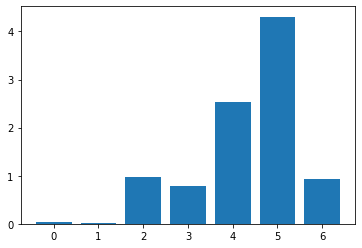

In [81]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

importance = model.coef_

feat_names = ['Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density']

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

From this we can see that feature 2,4 and 5 are important, but feature 3 and 6 are close. 

Feature: 0, Cruise_line, Score: 0.0037798920707793064
Feature: 1, Age, Score: 0.017210642906392574
Feature: 2, cabins, Score: 0.15272545274361976
Feature: 3, crew, Score: 0.05027676078836866
Feature: 4, passengers, Score: 0.3623913011429262
Feature: 5, length, Score: 0.4085035903837652
Feature: 6, passenger_density, Score: 0.005112359964148329


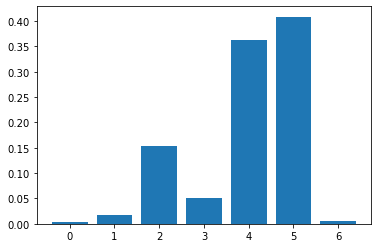

In [78]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

model = RandomForestRegressor()

model.fit(X_train, y_train)
importance = model.feature_importances_

feat_names = ['Cruise_line', 'Age', 'cabins', 'crew', 'passengers',
       'length', 'passenger_density']

for i,v in enumerate(importance):
	print('Feature: {0}, {1}, Score: {2}'.format(i, feat_names[i],v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature 2: cabins
Feature 4: passengers
Feature 5: length 
These feature using a RF seem to have the highest feature importance. 

Cruise_line and passenger_density seem to have the lowest feature importance 

<AxesSubplot:>

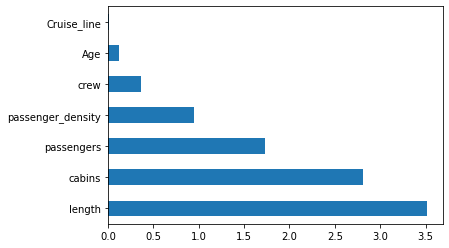

In [77]:
from sklearn.svm import SVR  

model = SVR(kernel = 'linear')

model.fit(X_train, y_train)

pd.Series(abs(model.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh')




Similar to Linear Regression and RF, passengers, cabins and length seem to have the highest correlation with the output value. 

So although the feature importance seems similar for both models, they might depend on the model used. Further analysis is necessary, but we might carefully say that number of cabins, number of passengers and length are important feature for determination of the output value, while cruise line and age are less important. 

It is actually quite interesting, because passenger_density * passengers gives gross tonnage, which is why I've expected that passengers and passenger_density both had higher feature importances. 

## Part 4: Create new features
As we've seen previously, some of the features in the dataset are important for prediction of the gross tonnage, while other features are not. 

To make better predictions based on features, combinations of existing features might be predictors of the gross tonnage as well. 

Manually engineering features to improve the prediction power of the models:
- Passenger per cabin  
- Cabins per length 
- Passengers per length
- Total number of people by adding crew and passengers 

In [93]:
# Passenger per cabin 
# Cabins x 10
# Passengers x 100
# Length is in foot? Foot = 0.3 meter x 100
for i in range(158):
    X["passenger_per_cabin"] = X["cabins"] / (X["passengers"] / 10)
    X["length_per_cabin"] = X["cabins"] / X["length"]
    X["passengers_per_length"] = X["length"] / X["passengers"]
    X["total_people"] = X["crew"] + X["passengers"]

X





,Cruise_line,Age,cabins,crew,passengers,length,passenger_density,passenger_per_cabin,length_per_cabin,passengers_per_length,total_people
0,0,6,3.55,3.55,6.94,5.94,42.64,5.115274,0.597643,0.855908,10.49
1,0,6,3.55,3.55,6.94,5.94,42.64,5.115274,0.597643,0.855908,10.49
2,1,26,7.43,6.70,14.86,7.22,31.80,5.000000,1.029086,0.485868,21.56
3,1,11,14.88,19.10,29.74,9.53,36.99,5.003362,1.561385,0.320444,48.84
4,1,17,13.21,10.00,26.42,8.92,38.36,5.000000,1.480942,0.337623,36.42
...,...,...,...,...,...,...,...,...,...,...,...
153,18,22,0.33,0.59,0.66,2.79,50.62,5.000000,0.118280,4.227273,1.25
154,18,14,9.67,12.00,19.60,8.79,39.18,4.933673,1.100114,0.448469,31.60
155,19,25,0.74,0.88,1.58,4.40,33.86,4.683544,0.168182,2.784810,2.46
156,19,27,0.74,0.88,1.67,4.40,32.04,4.431138,0.168182,2.634731,2.55


To decrease the influence of large differences between numbers, all data is normalised and scaled 

## Part 5: Choose algorithm 
The algorithm of choice is determined by cross validation. The models compared are Linear Regression, Random Forests and Support Vector Machine Regression. 

As the data might be linear, Linear Regression would work fine by the KISS principle: keep it simple stupid. Why use a complex model that is more difficult to explain if we can also use a very simple model that is easy to interpret?

The Random Forest creates different Decision trees and takes the average prediction. However, it cannot extrapolate, meaning that it is not able to obtain values outside ethe train set during prediction. It is not the best model when the data is linear. 

The third model is Support Vector Machine Regression. Essentially it is also a linear model, but it is able to handle non-linear data by using the kernel trick. The kernel trick is able to transform the feature space into a non-linear space, while the classifier is still linear in the transformed feature space. 

The last model is Gradient boosting 

The model will be evaluated using Mean Squared Error, the coefficient of determination and accuracy. These metrics provide a baseline which we try to improve with hyperparameter tuning. 



## Part 6: Hyperparameter tuning

## Part 7a: Testing per model

## Part 7b: Testing ensemble of models 

Because different models give (possibly) different predictions, combining the base models gives a meta-model. The meta-model, or Level-1 model learns how to combine the predictions of the Level-0 models (base models) in an optimal form. The meta-model is trained on the predictions from the separate base models on an unseen data sample. 